# Pipeline Project

You will be using the provided data to create a machine learning model pipeline.

You must handle the data appropriately in your pipeline to predict whether an
item is recommended by a customer based on their review.
Note the data includes numerical, categorical, and text data.

You should ensure you properly train and evaluate your model.

## The Data

The dataset has been anonymized and cleaned of missing values.

There are 8 features for to use to predict whether a customer recommends or does
not recommend a product.
The `Recommended IND` column gives whether a customer recommends the product
where `1` is recommended and a `0` is not recommended.
This is your model's target/

The features can be summarized as the following:

- **Clothing ID**: Integer Categorical variable that refers to the specific piece being reviewed.
- **Age**: Positive Integer variable of the reviewers age.
- **Title**: String variable for the title of the review.
- **Review Text**: String variable for the review body.
- **Positive Feedback Count**: Positive Integer documenting the number of other customers who found this review positive.
- **Division Name**: Categorical name of the product high level division.
- **Department Name**: Categorical name of the product department name.
- **Class Name**: Categorical name of the product class name.

The target:
- **Recommended IND**: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.

## Load Data

In [1]:
# ! python -m spacy download en_core_web_sm

In [2]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report



# Load data
df = pd.read_csv(
    'data/reviews.csv',
)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18442 entries, 0 to 18441
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              18442 non-null  int64 
 1   Age                      18442 non-null  int64 
 2   Title                    18442 non-null  object
 3   Review Text              18442 non-null  object
 4   Positive Feedback Count  18442 non-null  int64 
 5   Division Name            18442 non-null  object
 6   Department Name          18442 non-null  object
 7   Class Name               18442 non-null  object
 8   Recommended IND          18442 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.3+ MB


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name,Recommended IND
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses,0
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants,1
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses,1
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses,0
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits,1


#### No missing values in the dataset. However 'Clothing ID' & 'Recommended IND' will be handled as categorical.

## Data Exploration

In [4]:
#viewing summary statistics with focus on Age 
df.describe()

,Clothing ID,Age,Positive Feedback Count,Recommended IND
count,18442.000000,18442.000000,18442.000000,18442.000000
mean,954.896757,43.383635,2.697484,0.816235
std,141.571783,12.246264,5.942220,0.387303
min,2.000000,18.000000,0.000000,0.000000
25%,863.000000,34.000000,0.000000,1.000000
50%,952.000000,41.000000,1.000000,1.000000
75%,1078.000000,52.000000,3.000000,1.000000
max,1205.000000,99.000000,122.000000,1.000000


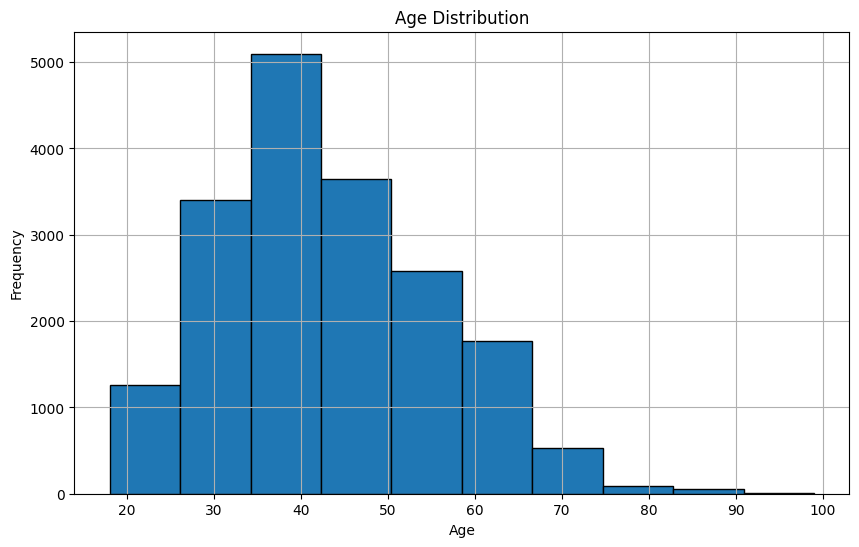

In [5]:
# Plotting the age distribution
plt.figure(figsize=(10, 6))
plt.hist(df['Age'], bins=10, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### Looking to see if the age influences recommendations in some way. 

<Figure size 1000x600 with 0 Axes>

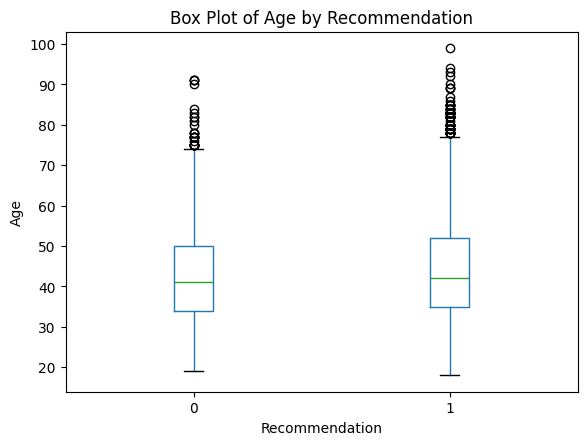

The average age of those that scored 0 is 42.44
The average age of those that scored 1 is 43.60


In [6]:
# Plot the box plot of Recommendations.
plt.figure(figsize=(10, 6))
df.boxplot(column='Age', by='Recommended IND', grid=False)
plt.title('Box Plot of Age by Recommendation')
plt.suptitle('')
plt.xlabel('Recommendation')
plt.ylabel('Age')
plt.show()

# Calculate the average age of those that scored 0 and those that scored 1
average_age_score_0 = df[df['Recommended IND'] == 0]['Age'].mean()
average_age_score_1 = df[df['Recommended IND'] == 1]['Age'].mean()

print(f"The average age of those that scored 0 is {average_age_score_0:.2f}")
print(f"The average age of those that scored 1 is {average_age_score_1:.2f}")

In [7]:
#Reviewing entries where age is above 80. looks ok.
# Filter the dataset where Age is above 80
filtered_df = df[df['Age'] > 80]

# View the portion of the dataset with Age above 80, focusing on the Review column
filtered_df[['Age', 'Review Text']]

,Age,Review Text
66,83,"Purchased this top online, and when i received..."
170,83,I ordered this top in my usual size and am exc...
206,83,"Love this top!\nit is a full/ swing top, but t..."
647,82,"I am 5'4"" 140 pounds and ordered the 8 petite...."
762,83,I saw this and tried to wait for it to go on s...
...,...,...
17601,83,"I ordered this online, with a little hesitatio..."
17690,84,I saw this t on sale and ordered it. i had sec...
17860,83,Received this jacket yesterday...and it is lov...
18053,83,I found this top to be very beautiful and well...


In [8]:
#Percentage of recommendations vs non-recommendations
df['Recommended IND'].value_counts()/df.shape[0] * 100

Recommended IND
1    81.623468
0    18.376532
Name: count, dtype: float64

In [9]:
df['Full Review'] = df['Title'] + ". " + df['Review Text'] #combined Title and Review Text into one feature
df

,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name,Recommended IND,Full Review
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses,0,Some major design flaws. I had such high hopes...
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants,1,"My favorite buy!. I love, love, love this jump..."
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses,1,Flattering shirt. This shirt is very flatterin...
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses,0,Not for the very petite. I love tracy reese dr...
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits,1,Cagrcoal shimmer fun. I aded this in my basket...
...,...,...,...,...,...,...,...,...,...,...
18437,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,0,General Petite,Dresses,Dresses,1,Great dress for many occasions. I was very hap...
18438,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",0,General Petite,Tops,Knits,1,Wish it was made of cotton. It reminds me of m...
18439,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",1,General Petite,Dresses,Dresses,0,"Cute, but see through. This fit well, but the ..."
18440,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,2,General,Dresses,Dresses,1,"Very cute dress, perfect for summer parties an..."


## Preparing features (`X`) & target (`y`)

In [10]:
data = df

# separate features from labels
X = data.drop(['Recommended IND', 'Title' , 'Review Text'], axis=1)
y = data['Recommended IND'].copy()

print('Labels:', np.unique(y))
print('Features:')
display(X.head())

Labels: [0 1]
Features:


,Clothing ID,Age,Positive Feedback Count,Division Name,Department Name,Class Name,Full Review
0,1077,60,0,General,Dresses,Dresses,Some major design flaws. I had such high hopes...
1,1049,50,0,General Petite,Bottoms,Pants,"My favorite buy!. I love, love, love this jump..."
2,847,47,6,General,Tops,Blouses,Flattering shirt. This shirt is very flatterin...
3,1080,49,4,General,Dresses,Dresses,Not for the very petite. I love tracy reese dr...
4,858,39,1,General Petite,Tops,Knits,Cagrcoal shimmer fun. I aded this in my basket...


In [11]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    shuffle=True,
    random_state=27,
)

In [12]:
#split data into numerical, categorical, and text features
num_features = (
    X
    .select_dtypes(include=['int64']).columns
    .drop(
        [
            'Clothing ID',  # More of a category than a numerical feature
        ],
    )
)
print('Numerical features:', num_features)

cat_features = (
    X[[
        'Division Name',
        'Department Name',
        'Class Name',
        'Clothing ID',
     ]].columns
)
print('Categorical features:', cat_features)


text_feature = (
    X[[
        'Full Review',
    ]].columns
)

print ('Review Text feature:', text_feature)



Numerical features: Index(['Age', 'Positive Feedback Count'], dtype='object')
Categorical features: Index(['Division Name', 'Department Name', 'Class Name', 'Clothing ID'], dtype='object')
Review Text feature: Index(['Full Review'], dtype='object')


## Building Pipeline

### Numerical Features Preprocessing Pipeline

#### Though this pipeline handles missing values, there are no missing values in the dataset

In [13]:
#define pipeline for numerical features

num_pipeline = Pipeline([
    (
        'imputer',
        SimpleImputer(strategy='mean'),
    ),
    (
        'scaler',
        MinMaxScaler(),
    ),
])

num_pipeline

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler())])

### Categorical Features Preprocessing Pipeline

In [14]:

# Define the preprocessing pipeline for categorical features
cat_pipeline = Pipeline([
    ('ordinal_encoder', 
     OrdinalEncoder(handle_unknown='use_encoded_value', 
    unknown_value=-1)
    ),
    (
        'imputer',
        SimpleImputer(strategy='most_frequent'),
    ),
    (
    'onehot_encoder', 
    OneHotEncoder(sparse_output=False, 
    handle_unknown='ignore')
    )
])
cat_pipeline

Pipeline(steps=[('ordinal_encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot_encoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

### Text Features Preprocessing Pipeline

In [15]:
#Lemmatizer class which is modified to perform normalization. nlp.pipe(X) handles tokenization

class SpacyLemmatizer(BaseEstimator, TransformerMixin):
    def __init__(self, nlp):
        self.nlp = nlp
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Ensure X is a list of text strings
        if isinstance(X, pd.DataFrame):
            X = X.iloc[:, 0].tolist()  # Convert the first column to a list
        elif isinstance(X, np.ndarray):
            X = X.tolist()
        elif isinstance(X, pd.Series):
            X = X.tolist()

             
        # Normalization: Convert lemmas to lowercase and remove punctuation
        normalized = []
        for doc in self.nlp.pipe(X):
            normalized_text = ' '.join(
                token.lemma_.lower() for token in doc
                if not token.is_stop and not token.is_punct
            )
            normalized.append(normalized_text)
        
       return normalized


In [16]:
# Define the tfidf pipeline
tfidf_pipeline = Pipeline([  
    (
        'lemmatizer',
        SpacyLemmatizer(nlp=nlp),
    ),
  
    (
        'tfidf_vectorizer',
        TfidfVectorizer(stop_words='english'),
    ),
])

### Feature Engineering Pipeline

In [17]:
# Feature engineering pipeline which combines all pipelines
feature_engineering = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features),
    ('tfidf_text', tfidf_pipeline, text_feature),
])




## Training Pipeline

In [18]:

# Define the final model training pipeline
model_pipeline = make_pipeline(
    feature_engineering, 
    RandomForestClassifier(), 
)


# Train the model
model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Age', 'Positive Feedback Count'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinal_encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='m...
                                                  Index(['Division Name', 'Department Name', 'Class Name', 'Clothing ID'], dtype='object')),
                                                 ('tfidf_text',
                                                  Pipeline(steps=[('lemmatizer',
                                                                   SpacyLemmatizer(nlp=<spacy.lang.en.English object at 0x000001A75131BE90>)),
                                                                  ('tfidf_vectorizer',
                                                                   TfidfVectorizer(stop_words='english'))]),
                                                  Index(['Full Review'], dtype='object'))])),
                ('randomforestclassifier', RandomForestClassifier())])

## Evaluation

In [19]:
from sklearn.metrics import accuracy_score

y_pred = model_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")

Accuracy: 0.8612466124661247


## Fine-Tuning Pipeline

In [20]:

# fine tuning parameters

parameters = dict(
    randomforestclassifier__max_features=[100,150,250],
    randomforestclassifier__n_estimators=[150,200]
)

cv = GridSearchCV(model_pipeline, param_grid=parameters, cv=5,  n_jobs=-1, verbose=3)
  

cv.fit(X_train, y_train)

# Retrieve the best parameters
cv.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


{'randomforestclassifier__max_features': 250,
 'randomforestclassifier__n_estimators': 200}

In [22]:
#Predicting with the best estimator and comparing results with model above
best_model = cv.best_estimator_
best_model

y_pred_best_model = best_model.predict(X_test)
accuracy_best_model = accuracy_score(y_test, y_pred_best_model)
report_best_model = classification_report(y_test, y_pred)

print('Accuracy:', accuracy_best_model)
print("Classification Report:")
print(report_best_model)

Accuracy: 0.8682926829268293
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.26      0.40       327
           1       0.86      0.99      0.92      1518

    accuracy                           0.86      1845
   macro avg       0.86      0.63      0.66      1845
weighted avg       0.86      0.86      0.83      1845

